# Setup everything

### Do imports

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/dmalt/anaconda2/envs/brainpipe/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cond']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
# --- Import modules --- #
import numpy as np
import matplotlib.pyplot as plt

import os 
import os.path as op
import sys
import mne
from mne import pick_types, find_layout
from mne.io import read_info
from mne.viz import plot_topomap
from mne import stats as st
from custom_stats import *
from load_data import read_info_custom, LoadAutGamma

### Setup parameters

In [7]:
# ---------- Setup stuff for plotting  ------------ #
# info needed to get sensors positions
# For .ds files info in a case of missing channel should 
# pick info_file with 271 meg channels, not 272


#                            | CHANGE THIS  |
#                           \/             \/
info_file = '/media/dmalt/SSD500/aut_gamma/K0001/K0001/K0001ec-epo.fif' 
#                      /\   /\   /\   /\   /\   /\
#                      |    |    |    |    |    |
# ----------------------------------------------------------------------- #
    
info = read_info_custom(info_file)   # <-- works both with ctf and electa
layout = find_layout(info)           # <-- Get sensor positions. 

fsize = (16,7)
mask_params = dict(marker='*', markerfacecolor='m', markersize=10) # significant sensors appearence

In [8]:
# ----------- ONLY FOR ELECTA (.fif) ------------- #

# --- Setup indexing for different sensor types --- #
# For ctf data this should be changed #
grads1 = pick_types(info, meg='planar1')
grads2 = pick_types(info, meg='planar2')
mags   = pick_types(info, meg='mag')
grads  = pick_types(info, meg='grad')

ch_used = grads
sensors_pos = layout.pos[ch_used]
# ------------------------------------------------- #

# Interesting stuff starts here

### Load data 

In [9]:
ep_path = '/media/dmalt/SSD500/aut_gamma/Moscow_baseline_results_new/'
subj_names = dict()
subj_names['K'] = [s for s in os.listdir(ep_path) if len(s) == 5 and s.startswith('K')]
subj_names['R'] = [s for s in os.listdir(ep_path) if len(s) == 5 and s.startswith('R')]

In [10]:
# --------------- LOAD DATA --------------------- #
# This cell is dataset-specific.
# Load data for power statistical analysis for scz ctf dataset
# can be changed to plot connectivity. 
# Define paths to two folders which 
# contain data for two conditions we want to compare and load the data

# PREDEFINE:
# miss_ch_id       - missing channel 
# LoadSczPowerData - data loading function

# --------------------------------------------------------------- #
conds = ('ec', 'eo')
bands = ('delta', 'theta', 'alpha', 'beta', 'lowgamma', 'highgamma')
groups = ('K', 'R')

# --------------------------------------------------------------- #
basedir = '/media/dmalt/SSD500/aut_gamma/powers'

data = dict()
fnames = dict()

# ----------- Load all the data ------------ #
for cond in conds:
    data[cond] = dict()
    fnames[cond] = dict()    
    for band in bands:
        data[cond][band] = dict()
        fnames[cond][band] = dict()
        for group in groups:
            subdir = cond + '_' + band
            cond_dir = op.join(basedir, subdir, group)
            cond_data, cond_fnames = LoadAutGamma(cond_dir, subj_names[group])
            
#             #  ---- Mask bad subjects ---- #
#             bads_mask = np.array([subj_name in bad_subjects[cond] for subj_name in subj_names[group]])
#             cond_data.mask[bads_mask,:] = True
#             cond_fnames.mask[bads_mask] = True
            
            data[cond][band][group]  = cond_data
            fnames[cond][band][group] = cond_fnames
            
# ----------------------------------------- #
# print fnames['Closed']['alpha']['Controls']
# cond1_data = data['-------Closed']['alpha'][]

In [11]:
def rm_masked(masked_data):
    return masked_data.data[~np.all(masked_data.mask, axis=1),:]

In [12]:
cond = 'eo'
band = 'delta'

cond1_data =  rm_masked(data[cond][band]['K'])
cond1_data = cond1_data[:,ch_used]
fnames1 = fnames[cond][band]['K'].compressed()

cond2_data = rm_masked(data[cond][band]['R'])
cond2_data = cond2_data[:,ch_used]
fnames2 = fnames[cond][band]['R'].compressed()
# fnames1.shape

In [13]:
# Difference between eo and ec to chekc if statistics work
cond = 'eo'
band = 'alpha'

cond1_data =  rm_masked(data['eo'][band]['K'])
cond1_data = cond1_data[:,ch_used]
fnames1 = fnames['eo'][band]['K'].compressed()

cond2_data = rm_masked(data['ec'][band]['K'])
cond2_data = cond2_data[:,ch_used]
fnames2 = fnames['ec'][band]['K'].compressed()

In [14]:
# Do normalization

# No normalization
cond1_data_norm = cond1_data
cond2_data_norm = cond2_data

# By mean
# cond1_data_norm = cond1_data / cond1_data.mean(axis=1)[:,None]
# cond2_data_norm = cond2_data / cond2_data.mean(axis=1)[:,None]

# By max
# cond1_data_norm = cond1_data / cond1_data.max(axis=1)[:,None]
# cond2_data_norm = cond2_data / cond2_data.max(axis=1)[:,None]

# Z-scores
# cond1_data_norm = (cond1_data - cond1_data.mean(axis=1)[:,None]) / cond1_data.std(axis=1)[:,None]
# cond2_data_norm = (cond2_data - cond2_data.mean(axis=1)[:,None]) / cond2_data.std(axis=1)[:,None]

In [15]:
# ----- statistical mask setup --------- #
# thresh = 0.05
# thresh = 0.01
thresh = 0.001

# stat_test_func = fdr(no_corr_mannwhitneyu)
stat_test_func = fdr(scipy_ttest_ind)
# stat_test_func = no_corr_mannwhitneyu
# stat_test_func = fdr(unpair_no_corr_t_test)
# stat_test_func = unpair_no_corr_t_test
# stat_test_func = unpair_clust_f_test
# stat_test_func = fdr(unpair_no_corr_perm_t_test)

mask, p_vals, stat = GetStatMask(cond1_data_norm, cond2_data_norm, stat_test_func=stat_test_func, p_thresh=thresh)
print 'Indices of significant sensors:', [i for i in xrange(len(p_vals)) if p_vals[i] < thresh]
# p_vals

SyntaxError: invalid syntax (<ipython-input-15-ebe0b2fe877c>, line 15)

CONDITION: eo, BAND: alpha


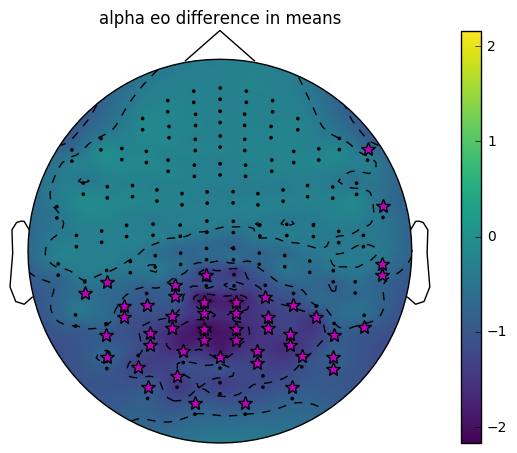

In [ ]:
# Plot mean difference and the variance of this difference between groups
print 'CONDITION: {}, BAND: {}'.format(cond, band)

# Relative change in mean:
data_mean = np.divide(cond1_data_norm.mean(axis=0) - cond2_data_norm.mean(axis=0), cond1_data_norm.mean(axis=0)) 
# data_mean = cond1_data_norm.mean(axis=0) - cond2_data_norm.mean(axis=0)
fig = plt.figure(figsize=(8,5))

ax,_ = plot_topomap(data_mean, sensors_pos, mask=mask, mask_params=mask_params,
                    cmap='viridis', show=False)#, vmin=-2.4e-27, vmax=2.4e-27)
plt.title(band + ' ' + cond + ' ' + 'difference in means')
fig.colorbar(ax)#, shrink=0.2)

plt.show()
plt.close(fig)

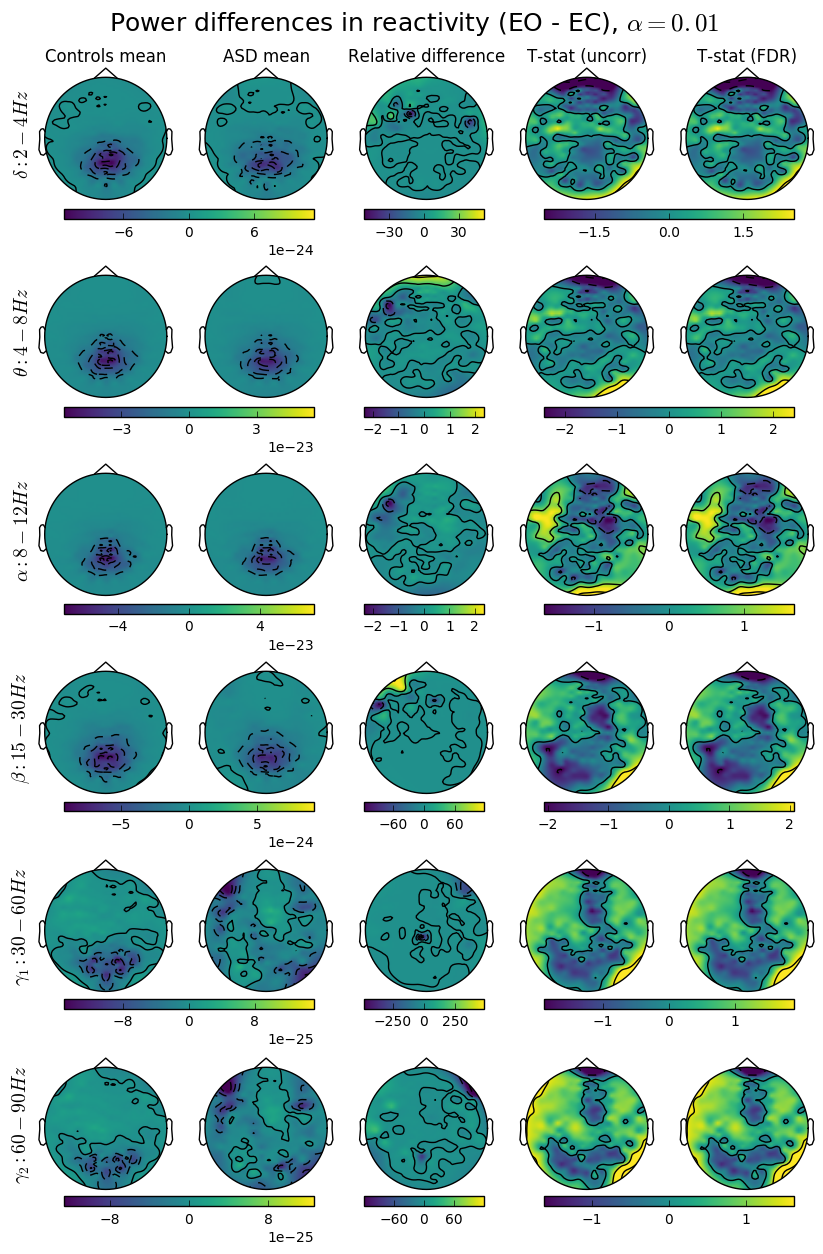

In [10]:
from matplotlib.ticker import *
MaxNLocator.default_params['nbins'] = 5

thresh = 0.01
cond = 're'
cmap = 'viridis'

ttest_fdr    = fdr(scipy_ttest_ind)
ttest_uncorr = scipy_ttest_ind


if cond == 'eo':
    cond_name = 'eyes open'
elif cond == 'ec':
    cond_name = 'eyes closed'
elif cond == 're':
    cond_name = 'reactivity (EO - EC)'

fig = plt.figure(figsize=(10,14))
n_rows = 6
n_cols = 5
band_titles = [r'$\delta: 2 - 4 Hz$', r'$\theta: 4-8 Hz$',
               r'$\alpha: 8-12 Hz$', r'$\beta:15-30 Hz$', r'$\gamma_1: 30-60 Hz$',
               r'$\gamma_2: 60-90 Hz$']
# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(9.75, 3))
# fig.title('Mann-Whitney U-test, significance value  = {}'.format(thresh))
# fig, axes = plt.subplots(nrows=25, ncols=25, sharex=True, sharey=True)
# fig.set_size_inches(16,14)
    
for iBand, (band, band_title) in enumerate(zip(bands, band_titles)):
    
    if cond != 're':
        cond1_data =  rm_masked(data[cond][band]['K'])
        cond1_data = cond1_data[:,ch_used]
        fnames1 = fnames[cond][band]['K'].compressed()

        cond2_data = rm_masked(data[cond][band]['R'])
        cond2_data = cond2_data[:,ch_used]
        fnames2 = fnames[cond][band]['R'].compressed()
    else:
        cond1_data = rm_masked(data['eo'][band]['K'] - data['ec'][band]['K'])
        cond1_data = cond1_data[:,ch_used]

        cond2_data = rm_masked(data['eo'][band]['R'] - data['ec'][band]['R'])
        cond2_data = cond2_data[:,ch_used]

    cond1_data_norm = cond1_data
    cond2_data_norm = cond2_data

    mean1 = cond1_data_norm.mean(axis=0)
    mean2 = cond2_data_norm.mean(axis=0)
    
    
    vmin = min(mean1.min(), mean2.min())
    vmax = max(mean1.max(), mean2.max())
    if cond == 're':
        vv = max(abs(vmin), abs(vmax))
        vmin = - vv
        vmax = vv
# --------------------------------------------------- #
    mask_t_uncorr, p_vals_t_uncorr, t_stat_uncorr = GetStatMask(cond1_data_norm,
                                                                cond2_data_norm,
                                                                stat_test_func=ttest_uncorr,
                                                                p_thresh=thresh)
    
    mask_t_fdr,    p_vals_fdr,      t_stat_fdr    = GetStatMask(cond1_data_norm,
                                                                cond2_data_norm,
                                                                stat_test_func=ttest_fdr,
                                                                p_thresh=thresh)

    data_mean = np.divide(mean1 - mean2, mean1)
    
    
    
    
# ------------- Controls mean ------------- #
    plt.subplot(n_rows, n_cols, n_cols * (iBand + 1) - n_cols + 1)
    if iBand == 0:
        plt.title('Controls mean')
    ax = plt.gca()
    ax.set_ylabel(band_title, fontsize=14)
    im,_ = plot_topomap(cond1_data_norm.mean(axis=0), 
                        sensors_pos, vmin=vmin, vmax=vmax,
                        cmap=cmap, contours=5, sensors=False, show=False)#, vmin=vmin, vmax=vmax)
    
# ------------- ASD mean ------------------ #
    plt.subplot(n_rows, n_cols, n_cols * (iBand + 1) - n_cols + 2)
    if iBand == 0:
        plt.title('ASD mean')
    ax = plt.gca()
    im,_ = plot_topomap(cond2_data_norm.mean(axis=0),
                        sensors_pos, vmin=vmin, vmax=vmax,
                        cmap=cmap, sensors=False,contours=5, show=False)#, vmin=vmin, vmax=vmax)
    
    cbar_ax = fig.add_axes([0.15, 0.83 - iBand * 0.141, 0.25, 0.007])
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

    
#  ------------ Relative difference ------------ #    
    plt.subplot(n_rows, n_cols, n_cols * (iBand + 1) - n_cols + 3)
    if iBand == 0:
        plt.title('Relative difference')
    im,_ = plot_topomap(data_mean, sensors_pos,
                        cmap=cmap, sensors=False,contours=5, show=False)#, vmin=vmin, vmax=vmax)
    
    cbar_ax = fig.add_axes([0.45, 0.83 - iBand * 0.141, 0.12, 0.007])
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# ------------------------------------------------- #

# --------------- T uncorrected ----------------- #
    plt.subplot(n_rows, n_cols, n_cols * (iBand + 1) - n_cols + 4)
    im,_ = plot_topomap(t_stat_uncorr, sensors_pos,
                        mask=mask_t_uncorr, 
                        mask_params=mask_params,
                        cmap=cmap, sensors=False,contours=5, show=False)#, vmin=vmin, vmax=vmax)
    
    if iBand == 0:
        plt.title('T-stat (uncorr)')
        
# --------------- T FDR -------------------------- #
    plt.subplot(n_rows, n_cols, n_cols * (iBand + 1)   )
    im,_ = plot_topomap(t_stat_fdr, sensors_pos,
                        mask=mask_t_fdr,
                        mask_params=mask_params,
                        cmap=cmap, sensors=False,contours=5, show=False)#, vmin=vmin, vmax=vmax)
    if iBand == 0:
        plt.title('T-stat (FDR)')
    cbar_ax = fig.add_axes([0.63, 0.83 - iBand * 0.141, 0.25, 0.007])
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
plt.suptitle(r'Power differences in {}, $\alpha = {}$'.format(cond_name, thresh), fontsize=18)

In [ ]:
# Plot all cond
vmin = min(cond1_data_norm.min(), cond2_data_norm.min()) * 5
vmax = max(cond1_data_norm.max(), cond2_data_norm.max()) / 5


for cond_data_norm,  fn, group in zip((cond1_data_norm, cond2_data_norm), (fnames1, fnames2), ('controls', 'patients')):
    n_iter = cond_data_norm.shape[0]
    subj_names = map(lambda s: s[:9], fn)
    fig = plt.figure(figsize=(14,14))
    # fig, axes = plt.subplots(nrows=25, ncols=25, sharex=True, sharey=True)
    fig.set_size_inches(16,14)

    for i in range(n_iter):
        plt.subplot(8,6,i + 1)
        ax = plt.gca()
        data_i = cond_data_norm[i,:]
        im,_ = plot_topomap(data_i, sensors_pos, cmap='viridis', show=False, vmin=vmin, vmax=vmax)
        title = subj_names[i]
        plt.title(title)
    main_title = band + ' ' + cond + ' ' + group 
    plt.suptitle(main_title, fontsize=20)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.show()
    plt.close(fig) 

In [16]:
from brainpipe.classification import *

from brainpipe.statistics import *
import scipy.io as sio

In [17]:
grp = [str(i) for i in range(306)]

In [18]:
band = 'delta'
cond = 'eo'
controls = rm_masked(data[cond][band]['K'])
patients = rm_masked(data[cond][band]['R'])

In [20]:
controls.shape
l_c = np.zeros((controls.shape[0]))
l_p = np.ones((patients.shape[0]))
target = np.concatenate((l_c, l_p)).T.astype(bool)
data_cat = np.concatenate((controls, patients), axis=0)


(59.782608695652172, 58.695652173913047, 63.04347826086957, 64.130434782608688, 61.95652173913043, 63.04347826086957, 56.521739130434781, 63.04347826086957, 60.869565217391312, 60.869565217391312, 57.608695652173914, 63.04347826086957, 63.04347826086957, 59.782608695652172, 56.521739130434781, 57.608695652173914, 56.521739130434781, 55.434782608695656, 54.347826086956516, 52.173913043478258, 55.434782608695656, 63.04347826086957, 54.347826086956516, 58.695652173913047, 57.608695652173914, 53.260869565217398, 61.95652173913043, 55.434782608695656, 57.608695652173914, 52.173913043478258, 54.347826086956516, 55.434782608695656, 56.521739130434781, 58.695652173913047, 56.521739130434781, 55.434782608695656, 51.086956521739133, 54.347826086956516, 56.521739130434781, 54.347826086956516, 54.347826086956516, 56.521739130434781, 54.347826086956516, 50.0, 54.347826086956516, 53.260869565217398, 53.260869565217398, 54.347826086956516, 53.260869565217398, 55.434782608695656, 60.869565217391312, 5

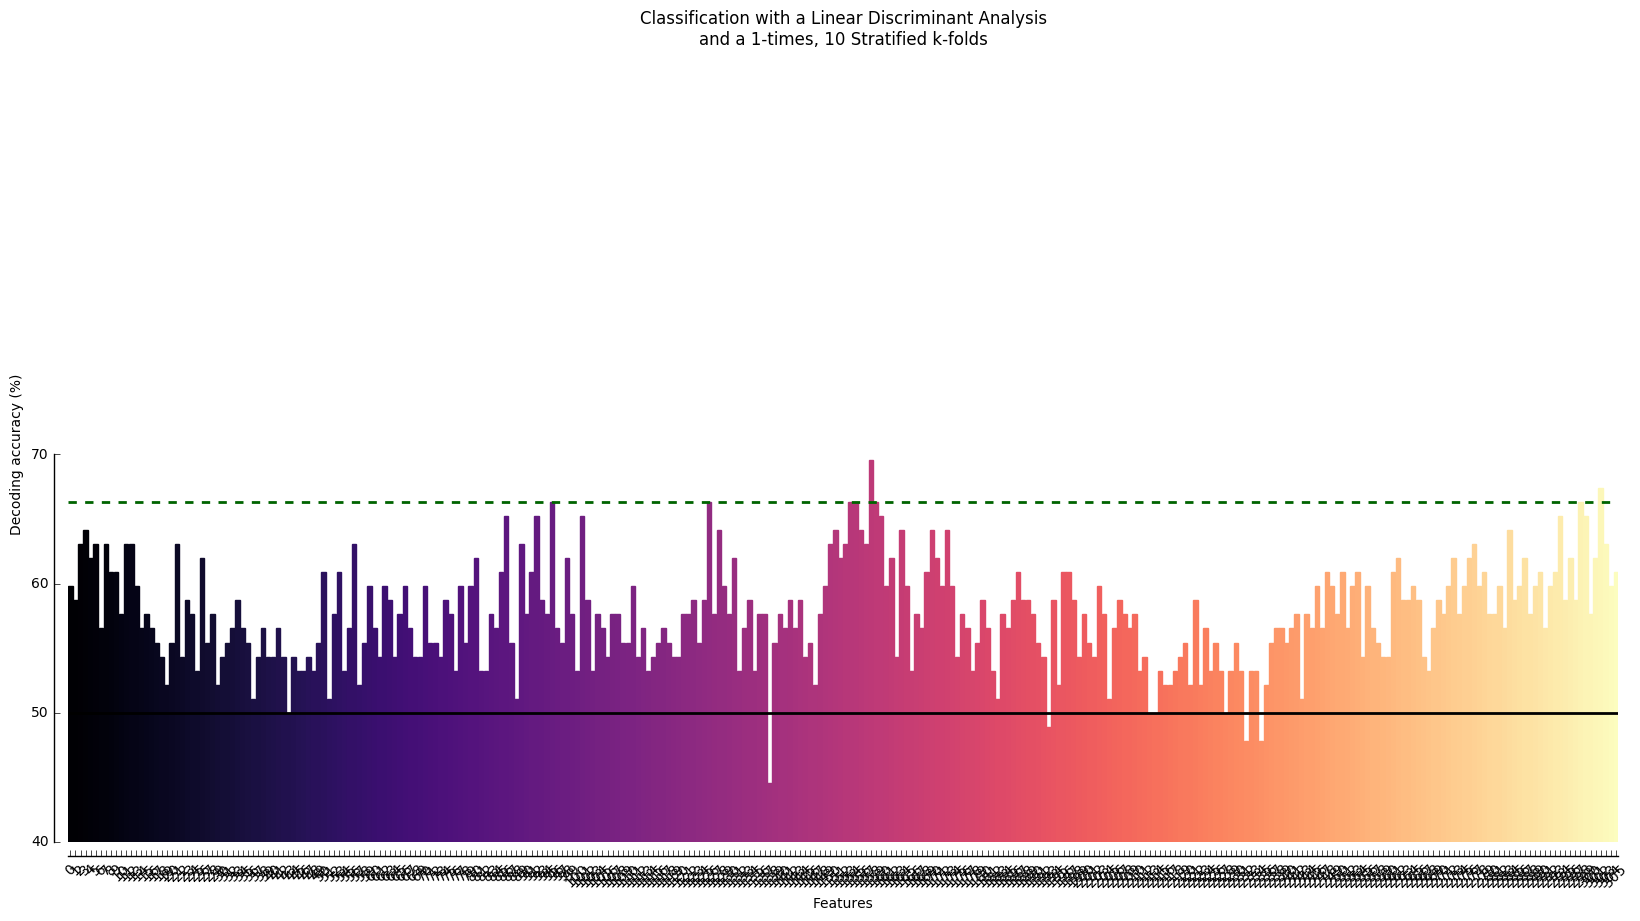

In [21]:
cv0 = defCv(target.T, rep = 1)
clf0 = defClf(target.T, clf='lda')
#print(clfO)

cl = classify(target, clf=clf0, cvtype=cv0)
#print(cl)


da, pvalue, daperm = cl.fit(data_cat, n_perm=20, grp=grp , method='label_rnd')

# sio.savemat(subject+'da_c2_new_sf_shallow_final_intra',{subject+'da_c2_new_sf_shallow_final_intra': da})
# sio.savemat(subject+'pvalue_c2_new_sf_shallow_final_intra',{subject+'pvalue_c2_new_sf_shallow_final_intra': pvalue})
# sio.savemat(subject+'da_perm_c2_new_sf_shallow_final_intra',{subject+'da_perm_c2_new_sf_shallow_final_intra': daperm})
# print(subject)
fig = plt.figure(1, figsize=(20,10))

cl.daplot(da, daperm=daperm, chance_method='perm', rmax=['top', 'right'],
        dpax=['bottom', 'left'], cmap='magma', ylim=[40,100], chance_unique=True,chance_level = 0.01,
        chance_color='darkgreen')
# fig.savefig(subject+'c2_new_sf_shallow_final.png', dpi=300, bbox_inches='tight')
# Display informations about features :
# cl.info.to_excel(subject+'c2_new_sf_shallow_final_intra.xlsx')
#plt.clf()
#plt.close()

In [15]:
cl.info

(92,)

In [22]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
X = data_cat
Y = target

clf = DecisionTreeClassifier()
clf = 
clf.fit(X,Y)

# importances = clf.feature_importances_
# print importances
# sortIndex = [i[0] for i in sorted(enumerate(importances), reverse=True, key = lambda x: x[1])]
# topFeatures = [features[i] for i in sortIndex[:2]]
# fname = 'trees.txt'
# f = open(fname, 'w')
# for item in topFeatures:
#   f.write(item + ' ')
# f.close()
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

# X = scale(X)

p_list = np.linspace(1, 10, 200)

cv = KFold(n=X.shape[0], n_folds=10, shuffle=True, random_state=42)

cross_val_score(clf, X, Y, scoring='accuracy', cv=cv)




array([ 0.3       ,  0.5       ,  0.44444444,  0.33333333,  0.33333333,
        0.33333333,  0.11111111,  0.22222222,  0.44444444,  0.33333333])

In [19]:
cross_val_score?